# Face Recognition on a subset of the Labeled Faces in the Wild dataset

In [3]:
%pylab inline

import pylab as pl
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## The LFW dataset

Let's start with downloading the data using a scikit-learn utility function.

In [4]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Let's introspect the images arrays to find the shapes (for plotting with matplotlib)

In [5]:
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = X.shape
_, h, w = lfw_people.images.shape
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

n_samples: 1288
n_features: 1850
n_classes: 7


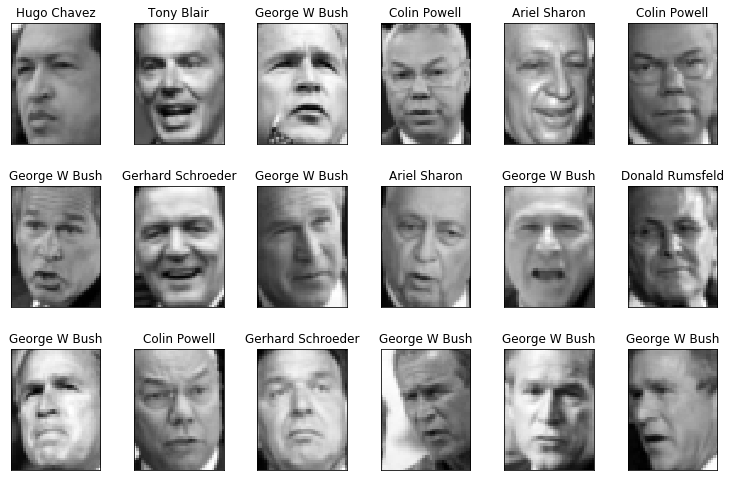

In [6]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

plot_gallery(X, names[y], h, w)

Let's have a look at the repartition among target classes:

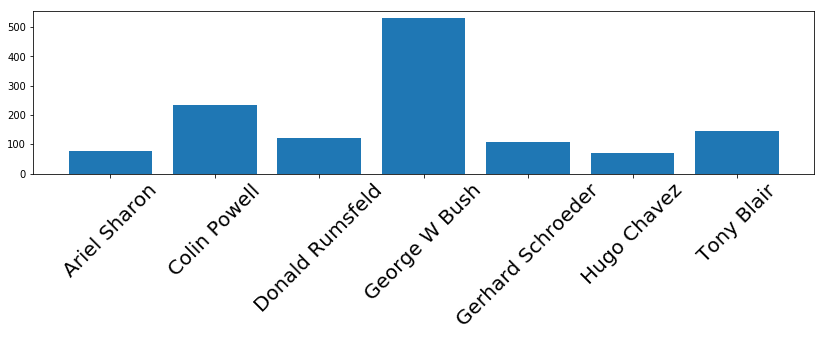

In [7]:
pl.figure(figsize=(14, 3))

y_unique = np.unique(y)
counts = [(y == i).sum() for i in y_unique]

pl.xticks(y_unique,  names[y_unique])
locs, labels = pl.xticks()
pl.setp(labels, rotation=45, size=20)
_ = pl.bar(y_unique, counts)

## Splitting the dataset for model development and then evaluation

Let's split the data in a development set and final evaluation set.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Unsupervised Feature Extraction with Randomized PCA

To train a model we will first reduce the dimensionality of the original picture to a 150 PCA space: unsupervised feature extraction.

In [9]:
from sklearn.decomposition import RandomizedPCA

n_components = 150
print((n_components, X_train.shape[0]))

'''print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])'''

pca = RandomizedPCA(n_components=n_components, whiten=True)

%time pca.fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

(150, 966)
CPU times: user 329 ms, sys: 23.8 ms, total: 353 ms
Wall time: 72.8 ms


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


Let's plot the gallery of the most significant eigenfaces:

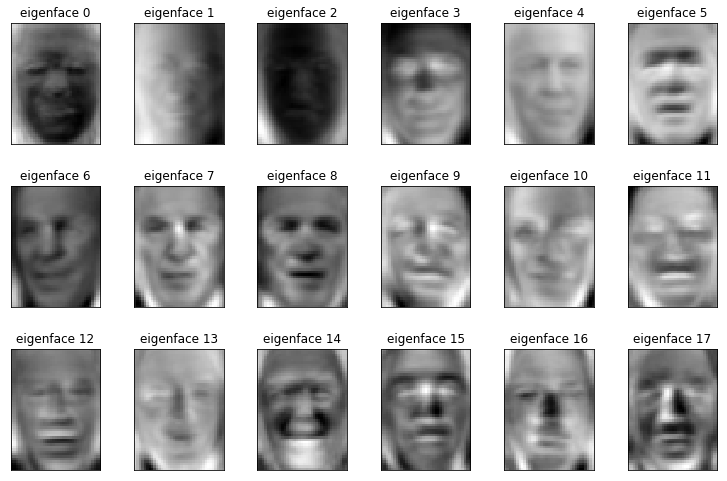

In [10]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

Projecting the input data on the eigenfaces orthonormal basis:

In [11]:
X_train_pca = pca.transform(X_train)

## Training a Gaussian Kernel Support Vector Machine

Let's now train a Kernel Support Vector Machine on the projected data. We perform an automated parameter search to find good values for Gamma and C:

In [12]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', class_weight='auto')

svm

SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Unfortunately an SVM is very sensitive to the parameters C and gamma and it's very unlikely that the default parameters will yield a good predictive accurracy:

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

cv = StratifiedShuffleSplit(y_train,test_size=0.20,n_splits=3)

%time svm_cv_scores = cross_val_score(svm, X_train_pca, y_train, scoring='f1', n_jobs=2)
svm_cv_scores

TypeError: __init__() got multiple values for argument 'n_splits'

In [12]:
svm_cv_scores.mean(), svm_cv_scores.std()

NameError: name 'svm_cv_scores' is not defined

## Data-driven hyper-parameters tuning using a Cross-Validated Grid Search

Fortunately we can automate the search for the best combination of parameters:

In [13]:
from sklearn.grid_search import GridSearchCV

param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

clf = GridSearchCV(svm, param_grid, scoring='f1', cv=cv, n_jobs=2)

/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [14]:
%time clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by randomized hyper parameter search:")
print(clf.best_params_)
print("Best parameters validation score: {:.3f}".format(clf.best_score_))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f2557a91b70, file "/...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f2557a91b70, file "/...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(11, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(11, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (11, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=11, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '%time clf = clf.fit(X_train_pca, y_train)\n\nprint...alidation score: {:.3f}".format(clf.best_score_))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 28, 0, 0, 23, 282829, tzinfo=tzutc()), 'msg_id': 'b4a5d948e9d74ecf8423d00de8df4e43', 'msg_type': 'execute_request', 'session': '8245ae7b01704feb8b4172e3eda954b9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'b4a5d948e9d74ecf8423d00de8df4e43', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'8245ae7b01704feb8b4172e3eda954b9']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '%time clf = clf.fit(X_train_pca, y_train)\n\nprint...alidation score: {:.3f}".format(clf.best_score_))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 28, 0, 0, 23, 282829, tzinfo=tzutc()), 'msg_id': 'b4a5d948e9d74ecf8423d00de8df4e43', 'msg_type': 'execute_request', 'session': '8245ae7b01704feb8b4172e3eda954b9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'b4a5d948e9d74ecf8423d00de8df4e43', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'8245ae7b01704feb8b4172e3eda954b9'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '%time clf = clf.fit(X_train_pca, y_train)\n\nprint...alidation score: {:.3f}".format(clf.best_score_))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 28, 0, 0, 23, 282829, tzinfo=tzutc()), 'msg_id': 'b4a5d948e9d74ecf8423d00de8df4e43', 'msg_type': 'execute_request', 'session': '8245ae7b01704feb8b4172e3eda954b9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'b4a5d948e9d74ecf8423d00de8df4e43', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='%time clf = clf.fit(X_train_pca, y_train)\n\nprint...alidation score: {:.3f}".format(clf.best_score_))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '%time clf = clf.fit(X_train_pca, y_train)\n\nprint...alidation score: {:.3f}".format(clf.best_score_))'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('%time clf = clf.fit(X_train_pca, y_train)\n\nprint...alidation score: {:.3f}".format(clf.best_score_))',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('%time clf = clf.fit(X_train_pca, y_train)\n\nprint...alidation score: {:.3f}".format(clf.best_score_))',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='%time clf = clf.fit(X_train_pca, y_train)\n\nprint...alidation score: {:.3f}".format(clf.best_score_))', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = '%time clf = clf.fit(X_train_pca, y_train)\n\nprint...alidation score: {:.3f}".format(clf.best_score_))'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='%time clf = clf.fit(X_train_pca, y_train)\n\nprint...alidation score: {:.3f}".format(clf.best_score_))', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-14-4c14f0bae910>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f25182487f0, executi...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f2517d7f8a0, file "<ipython-input-14-4c14f0bae910>", line 1>
        result = <ExecutionResult object at 7f25182487f0, executi...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f2517d7f8a0, file "<ipython-input-14-4c14f0bae910>", line 1>, result=<ExecutionResult object at 7f25182487f0, executi...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f2517d7f8a0, file "<ipython-input-14-4c14f0bae910>", line 1>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/home/ldeng/<ipython-input-14-4c14f0bae910> in <module>()
----> 1 get_ipython().run_line_magic('time', 'clf = clf.fit(X_train_pca, y_train)')
      2 
      3 print("Best estimator found by randomized hyper parameter search:")
      4 print(clf.best_params_)
      5 print("Best parameters validation score: {:.3f}".format(clf.best_score_))

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_line_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='clf = clf.fit(X_train_pca, y_train)', _stack_depth=1)
   2126             kwargs = {}
   2127             # Grab local namespace if we need it:
   2128             if getattr(fn, "needs_local_scope", False):
   2129                 kwargs['local_ns'] = sys._getframe(stack_depth).f_locals
   2130             with self.builtin_trap:
-> 2131                 result = fn(*args,**kwargs)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        args = ['clf = clf.fit(X_train_pca, y_train)']
        kwargs = {'local_ns': {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}}
   2132             return result
   2133 
   2134     def run_cell_magic(self, magic_name, line, cell):
   2135         """Execute the given cell magic.

...........................................................................
/home/ldeng/<decorator-gen-62> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='clf = clf.fit(X_train_pca, y_train)', cell=None, local_ns={'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...})

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, 'clf = clf.fit(X_train_pca, y_train)', None, {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}), **k={})
    182     validate_type(magic_kind)
    183 
    184     # This is a closure to capture the magic_kind.  We could also use a class,
    185     # but it's overkill for just that one bit of state.
    186     def magic_deco(arg):
--> 187         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, 'clf = clf.fit(X_train_pca, y_train)', None, {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...})
        k = {}
    188 
    189         if callable(arg):
    190             # "Naked" decorator call (just @foo, no args)
    191             func = arg

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/magics/execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='clf = clf.fit(X_train_pca, y_train)', cell=None, local_ns={'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...})
   1233                 return
   1234             end = clock2()
   1235         else:
   1236             st = clock2()
   1237             try:
-> 1238                 exec(code, glob, local_ns)
        code = <code object <module> at 0x7f2517d7fd20, file "<timed exec>", line 1>
        glob = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
        local_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
   1239             except:
   1240                 self.shell.showtraceback()
   1241                 return
   1242             end = clock2()

...........................................................................
/home/ldeng/<timed exec> in <module>()

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=StratifiedShuffleSplit(labels=[1...='2*n_jobs', refit=True, scoring='f1', verbose=0), X=array([[-0.45950255, -0.16551808, -0.06665047, ....        1.5468078 ,  1.6763616 ]], dtype=float32), y=array([1, 3, 1, 3, 6, 5, 3, 3, 4, 4, 3, 1, 3, 3,... 3, 6, 5, 1, 1, 3, 1, 3, 6, 1, 2, 1, 4, 1, 3, 3]))
    833         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    834             Target relative to X for classification or regression;
    835             None for unsupervised learning.
    836 
    837         """
--> 838         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...'2*n_jobs', refit=True, scoring='f1', verbose=0)>
        X = array([[-0.45950255, -0.16551808, -0.06665047, ....        1.5468078 ,  1.6763616 ]], dtype=float32)
        y = array([1, 3, 1, 3, 6, 5, 3, 3, 4, 4, 3, 1, 3, 3,... 3, 6, 5, 1, 1, 3, 1, 3, 6, 1, 2, 1, 4, 1, 3, 3])
        self.param_grid = {'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
    839 
    840 
    841 class RandomizedSearchCV(BaseSearchCV):
    842     """Randomized search on hyper parameters.

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=StratifiedShuffleSplit(labels=[1...='2*n_jobs', refit=True, scoring='f1', verbose=0), X=array([[-0.45950255, -0.16551808, -0.06665047, ....        1.5468078 ,  1.6763616 ]], dtype=float32), y=array([1, 3, 1, 3, 6, 5, 3, 3, 4, 4, 3, 1, 3, 3,... 3, 6, 5, 1, 1, 3, 1, 3, 6, 1, 2, 1, 4, 1, 3, 3]), parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    569         )(
    570             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    571                                     train, test, self.verbose, parameters,
    572                                     self.fit_params, return_parameters=True,
    573                                     error_score=self.error_score)
--> 574                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    575                 for train, test in cv)
    576 
    577         # Out is a list of triplet: score, estimator, n_test_samples
    578         n_fits = len(out)

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Sep 27 20:00:23 2018
PID: 3780                               Python 3.6.5: /anaconda3/bin/python
...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (SVC(C=1000.0, cache_size=200, class_weight='auto...None, shrinking=True,
  tol=0.001, verbose=False), array([[-0.45950255, -0.16551808, -0.06665047, ....        1.5468078 ,  1.6763616 ]], dtype=float32), array([1, 3, 1, 3, 6, 5, 3, 3, 4, 4, 3, 1, 3, 3,... 3, 6, 5, 1, 1, 3, 1, 3, 6, 1, 2, 1, 4, 1, 3, 3]), make_scorer(f1_score), array([260, 929,  99, 291, 663, 401, 641, 521, 6..., 507,  60, 798,
       115, 738, 720, 715,  46]), array([393,  68, 627, 209, 445, 510, 544, 752, 8...24, 827, 145, 163, 494, 900,  58,   0, 624, 661]), 0, {'C': 1000.0, 'gamma': 0.0001}, {}), {'error_score': 'raise', 'return_parameters': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (SVC(C=1000.0, cache_size=200, class_weight='auto...None, shrinking=True,
  tol=0.001, verbose=False), array([[-0.45950255, -0.16551808, -0.06665047, ....        1.5468078 ,  1.6763616 ]], dtype=float32), array([1, 3, 1, 3, 6, 5, 3, 3, 4, 4, 3, 1, 3, 3,... 3, 6, 5, 1, 1, 3, 1, 3, 6, 1, 2, 1, 4, 1, 3, 3]), make_scorer(f1_score), array([260, 929,  99, 291, 663, 401, 641, 521, 6..., 507,  60, 798,
       115, 738, 720, 715,  46]), array([393,  68, 627, 209, 445, 510, 544, 752, 8...24, 827, 145, 163, 494, 900,  58,   0, 624, 661]), 0, {'C': 1000.0, 'gamma': 0.0001}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=SVC(C=1000.0, cache_size=200, class_weight='auto...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[-0.45950255, -0.16551808, -0.06665047, ....        1.5468078 ,  1.6763616 ]], dtype=float32), y=array([1, 3, 1, 3, 6, 5, 3, 3, 4, 4, 3, 1, 3, 3,... 3, 6, 5, 1, 1, 3, 1, 3, 6, 1, 2, 1, 4, 1, 3, 3]), scorer=make_scorer(f1_score), train=array([260, 929,  99, 291, 663, 401, 641, 521, 6..., 507,  60, 798,
       115, 738, 720, 715,  46]), test=array([393,  68, 627, 209, 445, 510, 544, 752, 8...24, 827, 145, 163, 494, 900,  58,   0, 624, 661]), verbose=0, parameters={'C': 1000.0, 'gamma': 0.0001}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1670 
   1671     try:
   1672         if y_train is None:
   1673             estimator.fit(X_train, **fit_params)
   1674         else:
-> 1675             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseLibSVM.fit of SVC(C=1000.0, ca...one, shrinking=True,
  tol=0.001, verbose=False)>
        X_train = array([[-0.6158141 , -0.5611195 ,  0.60747325, ....        0.16373831,  1.0492057 ]], dtype=float32)
        y_train = array([3, 2, 3, 0, 3, 1, 6, 4, 0, 3, 3, 1, 3, 4,...0, 3, 3, 3, 3, 1, 1, 6, 3, 3, 0, 3,
       4, 3])
        fit_params = {}
   1676 
   1677     except Exception as e:
   1678         if error_score == 'raise':
   1679             raise

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py in fit(self=SVC(C=1000.0, cache_size=200, class_weight='auto...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[-0.61581409, -0.5611195 ,  0.60747325, .... -0.14259407,
         0.16373831,  1.04920566]]), y=array([3, 2, 3, 0, 3, 1, 6, 4, 0, 3, 3, 1, 3, 4,...0, 3, 3, 3, 3, 1, 1, 6, 3, 3, 0, 3,
       4, 3]), sample_weight=None)
    145         if sparse and self.kernel == "precomputed":
    146             raise TypeError("Sparse precomputed kernels are not supported.")
    147         self._sparse = sparse and not callable(self.kernel)
    148 
    149         X, y = check_X_y(X, y, dtype=np.float64, order='C', accept_sparse='csr')
--> 150         y = self._validate_targets(y)
        y = array([3, 2, 3, 0, 3, 1, 6, 4, 0, 3, 3, 1, 3, 4,...0, 3, 3, 3, 3, 1, 1, 6, 3, 3, 0, 3,
       4, 3])
        self._validate_targets = <bound method BaseSVC._validate_targets of SVC(C...one, shrinking=True,
  tol=0.001, verbose=False)>
    151 
    152         sample_weight = np.asarray([]
    153                                    if sample_weight is None
    154                                    else sample_weight, dtype=np.float64)

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py in _validate_targets(self=SVC(C=1000.0, cache_size=200, class_weight='auto...None, shrinking=True,
  tol=0.001, verbose=False), y=array([3, 2, 3, 0, 3, 1, 6, 4, 0, 3, 3, 1, 3, 4,...0, 3, 3, 3, 3, 1, 1, 6, 3, 3, 0, 3,
       4, 3]))
    497 
    498     def _validate_targets(self, y):
    499         y_ = column_or_1d(y, warn=True)
    500         check_classification_targets(y)
    501         cls, y = np.unique(y_, return_inverse=True)
--> 502         self.class_weight_ = compute_class_weight(self.class_weight, cls, y_)
        self.class_weight_ = undefined
        self.class_weight = 'auto'
        cls = array([0, 1, 2, 3, 4, 5, 6])
        y_ = array([3, 2, 3, 0, 3, 1, 6, 4, 0, 3, 3, 1, 3, 4,...0, 3, 3, 3, 3, 1, 1, 6, 3, 3, 0, 3,
       4, 3])
    503         if len(cls) < 2:
    504             raise ValueError(
    505                 "The number of classes has to be greater than one; got %d"
    506                 % len(cls))

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/utils/class_weight.py in compute_class_weight(class_weight='auto', classes=array([0, 1, 2, 3, 4, 5, 6]), y=array([3, 2, 3, 0, 3, 1, 6, 4, 0, 3, 3, 1, 3, 4,...0, 3, 3, 3, 3, 1, 1, 6, 3, 3, 0, 3,
       4, 3]))
     57     else:
     58         # user-defined dictionary
     59         weight = np.ones(classes.shape[0], dtype=np.float64, order='C')
     60         if not isinstance(class_weight, dict):
     61             raise ValueError("class_weight must be dict, 'balanced', or None,"
---> 62                              " got: %r" % class_weight)
        class_weight = 'auto'
     63         for c in class_weight:
     64             i = np.searchsorted(classes, c)
     65             if i >= len(classes) or classes[i] != c:
     66                 raise ValueError("Class label {} not present.".format(c))

ValueError: class_weight must be dict, 'balanced', or None, got: 'auto'
___________________________________________________________________________

Best estimator found by randomized hyper parameter search:


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

## Final evaluation of the best model on the held-out test set

Let's start with a qualitative inspection of the some of the predictions:

In [15]:
X_test_pca = pca.transform(X_test)
y_pred = clf.predict(X_test_pca)

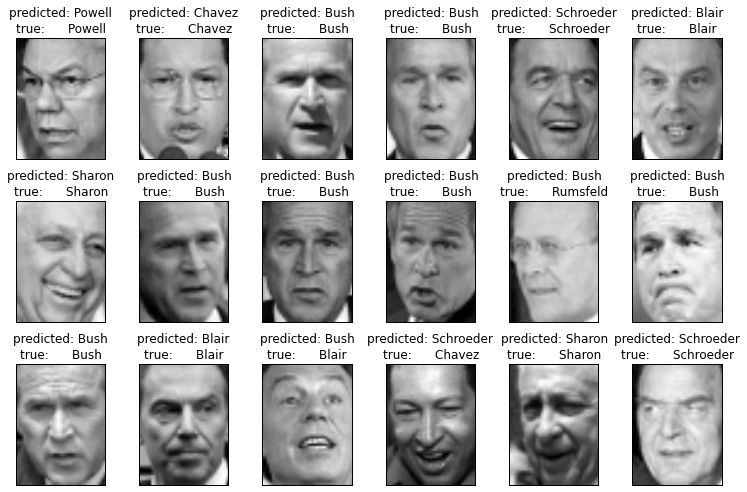

In [16]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.76      0.79        17
     Colin Powell       0.89      0.84      0.86        61
  Donald Rumsfeld       0.85      0.74      0.79        31
    George W Bush       0.90      0.96      0.93       134
Gerhard Schroeder       0.76      0.84      0.80        19
      Hugo Chavez       0.89      0.89      0.89        19
       Tony Blair       0.84      0.78      0.81        41

      avg / total       0.87      0.87      0.87       322



In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
print(cm)

[[ 13   2   1   1   0   0   0]
 [  2  51   0   4   1   0   3]
 [  0   1  23   5   1   1   0]
 [  1   1   2 129   0   0   1]
 [  0   0   1   0  16   1   1]
 [  0   0   0   0   1  17   1]
 [  0   2   0   5   2   0  32]]


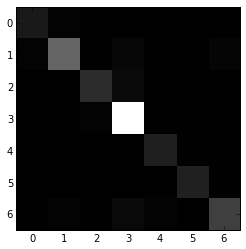

In [19]:
pl.gray()
_ = pl.imshow(cm, interpolation='nearest')